# Testing Clustering Methods on $^{16}O$ Data

This notebook tries different clustering methods to see if we get success with knowing (a priori) how many clusters we need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from spyral.core.run_stacks import form_run_string
import h5py as h5
import plotly.express as px
from spyral.core.point_cloud import PointCloud

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
run_to_examine = 30
event = 88
#event = 41470
#event = 1945978

In [3]:
workspace_path = Path("/Volumes/researchEXT/24Mg/mg24_spyral/")
pointcloud_path = workspace_path / "Pointcloud"
point_file_path = pointcloud_path / f"{form_run_string(run_to_examine)}.h5"
point_file = h5.File(point_file_path, 'r')
cloud_group: h5.Group = point_file.get('cloud')
min_event = cloud_group.attrs['min_event']
max_event = cloud_group.attrs['max_event']
event_iterator = iter(range(min_event, max_event+1))
print(f"First event: {min_event} Last event: {max_event}")

First event: 0 Last event: 20891


In [4]:
if event is None:
    try:
        event = next(event_iterator)
    except StopIteration:
        raise Exception("You ran out of events (wow!) for this file! Select a new file to analyze.")
print(f'Event {event}')
event_name = f"cloud_{event}"
if not event_name in cloud_group:
    raise Exception("This was a downscale beam event and has been removed from the analysis! Run this cell again to select a new event.")
event_data = cloud_group[f'cloud_{event}']
cloud = PointCloud(event, event_data[:].copy())
print(f'Cloud size: {len(cloud)}')
# Close any open plots to avoid memory problems
plt.close()

Event 88
Cloud size: 534


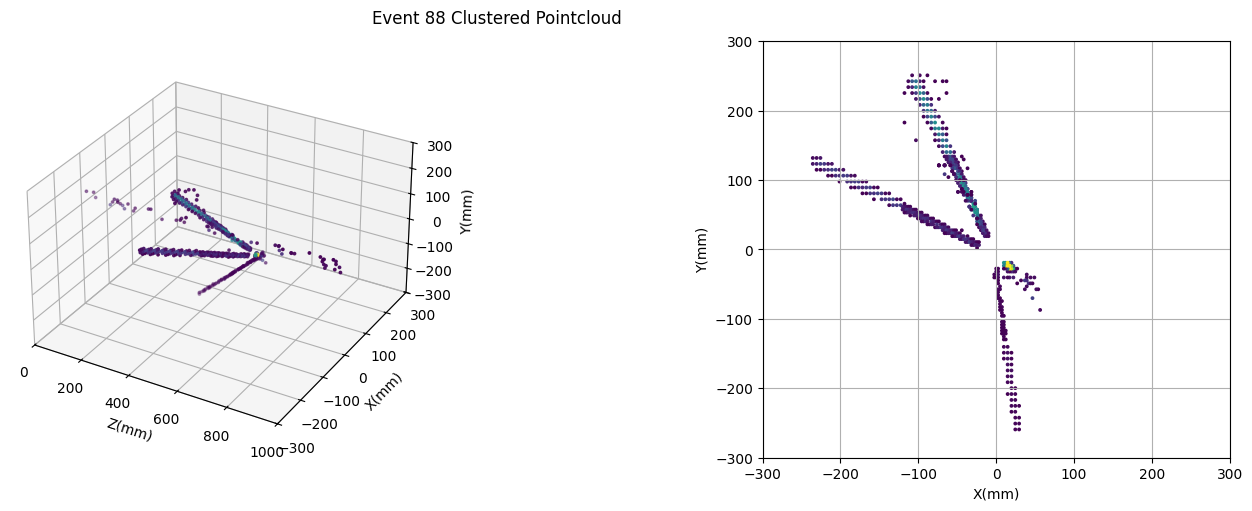

In [5]:
fig, axs = plt.subplot_mosaic(
    """
    AAB
    """,
    per_subplot_kw={
        "A": {
            "projection": "3d", 
            "box_aspect": (2,1,1),
            "aspect": "equalxy"
        }
    },
    figsize=(15.0, 5.0),
    constrained_layout=True
)
axs["A"].scatter(cloud.data[:, 2], cloud.data[:, 0], cloud.data[:, 1], c=cloud.data[:, 3], s=3, label="Pointcloud")
axs["A"].set_xlim3d(0., 1000.0)
axs["A"].set_xlabel("Z(mm)")
axs["A"].set_ylim3d(-300.0, 300.0)
axs["A"].set_ylabel("X(mm)")
axs["A"].set_zlim3d(-300.0, 300.0)
axs["A"].set_zlabel("Y(mm)")
axs["B"].scatter(cloud.data[:, 0], cloud.data[:, 1], c=cloud.data[:, 3], s=3)
axs["B"].set_xlim(-300.0, 300.0)
axs["B"].set_xlabel("X(mm)")
axs["B"].set_ylim(-300.0, 300.0)
axs["B"].set_ylabel("Y(mm)")
plt.suptitle(f"Event {event} Clustered Pointcloud")
axs["B"].grid()

In [6]:
print(cloud.data[:,:2])

[[-26.995293  65.88517 ]
 [-66.261177 121.14371 ]
 [-41.719997  99.890427]
 ...
 [-26.995293  65.88517 ]
 [-24.541176  44.631893]
 [-58.898823 121.14371 ]]


## k-means

In [7]:
X = cloud.data[:,:3]
X_scaled = StandardScaler().fit_transform(X)

In [8]:
silhouette_scores = []
k_range = range(1, 6)
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
y_pred = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# for n_clusters in k_range:
#     kmeans = KMeans(n_clusters=2, random_state=0)
#     y_pred = kmeans.fit_predict(X_scaled)
#     score = silhouette_score(X, y_pred)
#     silhouette_scores.append(score)

In [9]:
# print(centroids)

In [10]:
# print(silhouette_scores)

In [11]:
# plt.figure(figsize=(8, 5))
# plt.plot(k_range, silhouette_scores, marker='o')
# plt.xlabel("Number of Clusters (k)")
# plt.ylabel("Average Silhouette Score")
# plt.title("Silhouette Score for Optimal k Selection")
# plt.show()

# # 4. Select the k with the highest score
# optimal_k = k_range[np.argmax(silhouette_scores)]
# print(f"\nThe optimal number of clusters is likely: {optimal_k}")

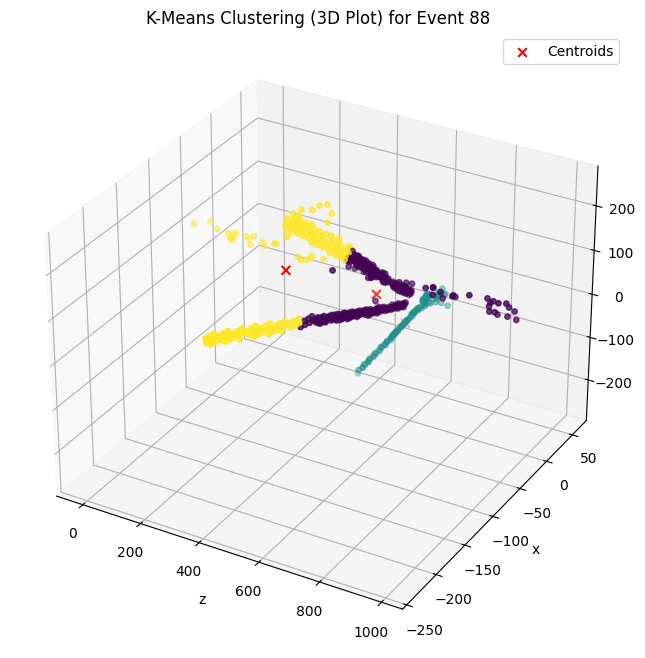

In [12]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 2],X[:, 0], X[:, 1], c=y_pred, cmap='viridis', s=15)

ax.scatter(centroids[:, 2],centroids[:, 0], centroids[:, 1], marker='x', s=40, c='red', label='Centroids')

ax.set_title(f'K-Means Clustering (3D Plot) for Event {event}')
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.legend()
plt.show()
plt.close(fig)

## gaussian mixture

In [13]:
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
        
gmm = GaussianMixture(n_components=3, covariance_type="full")
labels = gmm.fit_predict(X_scaled)

df = pd.DataFrame(X, columns=["x", "y", "z"])
df["cluster"] = labels.astype(str)

# Plot
fig = px.scatter_3d(
    df,
    x="z",
    y="x",
    z="y",
    color="cluster",
    opacity=0.6,
    title=f"GMM Clustering Results for Event {event}",
    width=800,
    height=600
    
)

fig.update_traces(marker=dict(size=4))
fig.show()


## spectral clustering

/Users/pranjalsingh/Desktop/research_space_spyral/Spyral_1.0/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



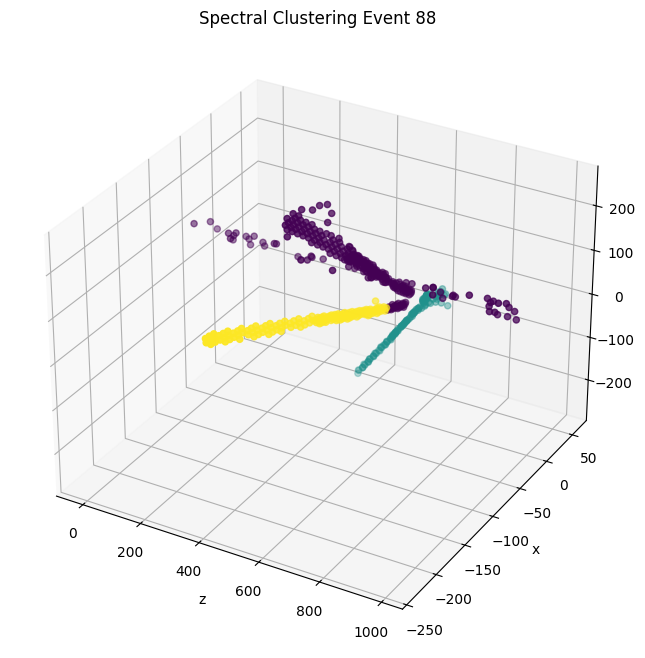

In [14]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=3,
    affinity="nearest_neighbors",
    n_neighbors=30,
    random_state=0)
y_pred = sc.fit_predict(X_scaled)

labels = sc.labels_

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title(f"Spectral Clustering Event {event}")
plt.xlabel("z")
plt.ylabel("x")
ax.set_zlabel("y")
plt.show()

## agglomerative clustering

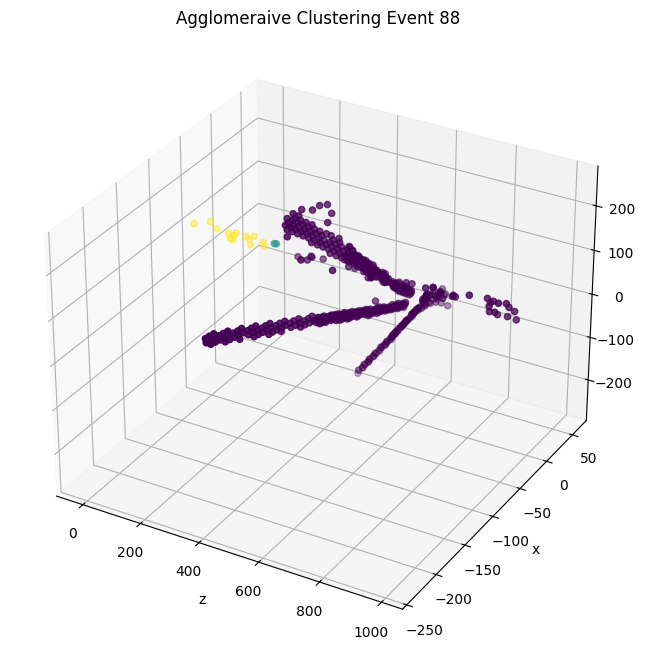

In [15]:
from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=3, metric="l1",linkage='single')
labels = agglo.fit_predict(X_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title(f"Agglomeraive Clustering Event {event}")
plt.xlabel("z")
plt.ylabel("x")
ax.set_zlabel("y")
plt.show()

## birch clustering

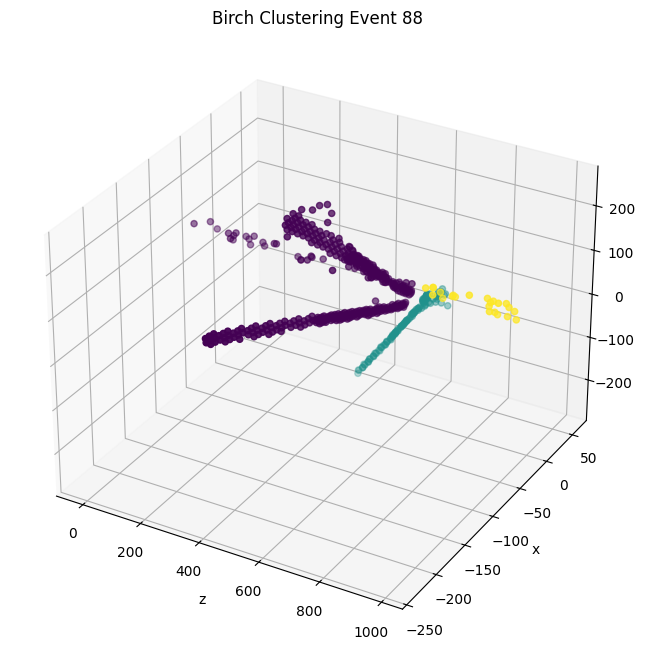

In [16]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=3, threshold=0.1, branching_factor=40)
labels_br = birch.fit_predict(X_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c=labels_br, cmap='viridis')
plt.title(f"Birch Clustering Event {event}")
plt.xlabel("z")
plt.ylabel("x")
ax.set_zlabel("y")
plt.show()

## optics

[-1  0  1]


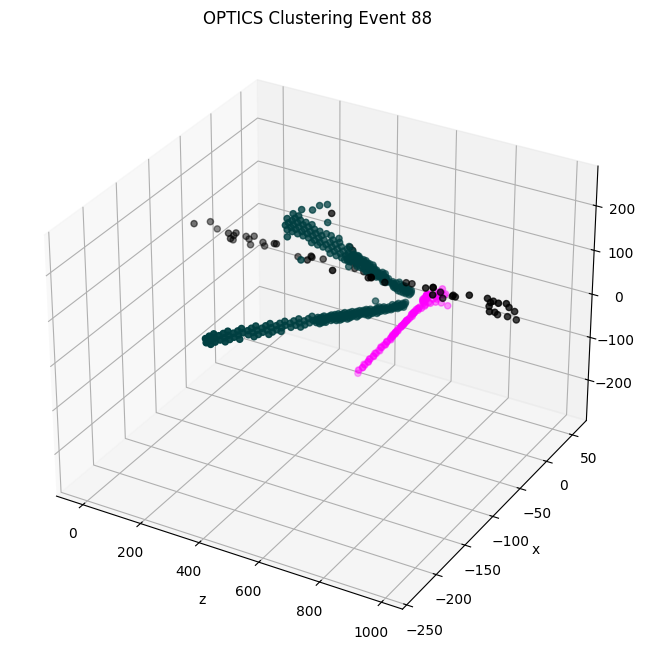

In [17]:
from sklearn.cluster import OPTICS
import matplotlib.colors as mcolors
optics = OPTICS(cluster_method='dbscan',eps=30, min_samples=10, algorithm="brute")
optics.fit(X)
labels_op = optics.labels_

colors = ["black", "darkred", "green", "navy", "orange",  "magenta"]

custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_gradient", colors
)

print(np.unique(labels_op))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c=labels_op, cmap=custom_cmap)
plt.title(f"OPTICS Clustering Event {event}")
plt.xlabel("z")
plt.ylabel("x")
ax.set_zlabel("y")
plt.show()


## bayesian gaussian mixture

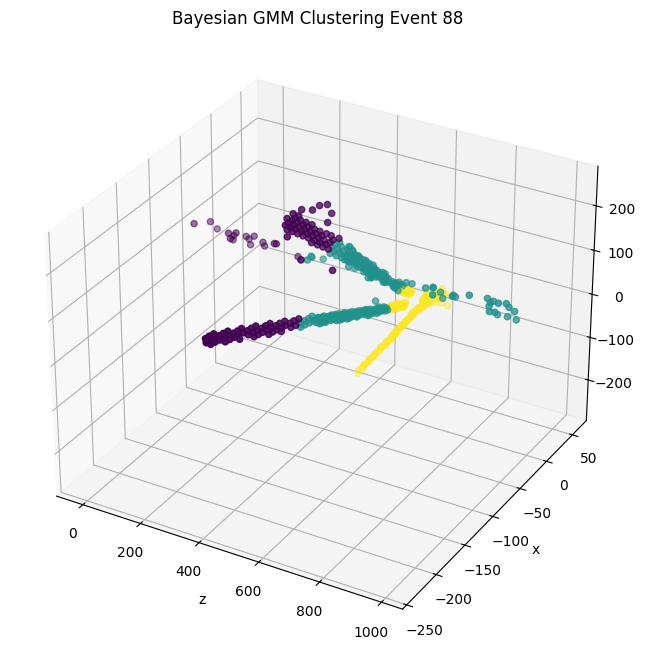

In [18]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=3, covariance_type="full")
labels = bgm.fit_predict(X_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.title(f"Bayesian GMM Clustering Event {event}")
plt.xlabel("z")
plt.ylabel("x")
ax.set_zlabel("y")
plt.show()  


## dbscan

[-1  0  1]


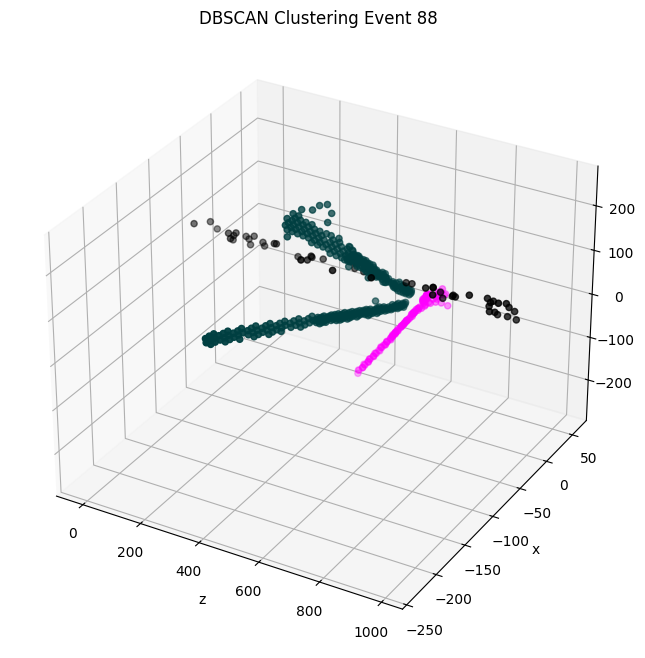

In [19]:
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors

# dbscan = DBSCAN(eps=0.4, min_samples=14, metric='euclidean', algorithm='brute', p=2)
dbscan = DBSCAN(eps=0.4, min_samples=14, metric='euclidean', algorithm='brute', p=2)
labels_db = dbscan.fit_predict(X_scaled)
print(np.unique(labels_db))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ["black", "darkred", "green", "navy", "orange",  "magenta"]

custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_gradient", colors
)
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c=labels_db, cmap=custom_cmap)
plt.title(f"DBSCAN Clustering Event {event}")
plt.xlabel("z")
plt.ylabel("x")
ax.set_zlabel("y")
plt.show()

## hdbscan

[-1  0  1  2]


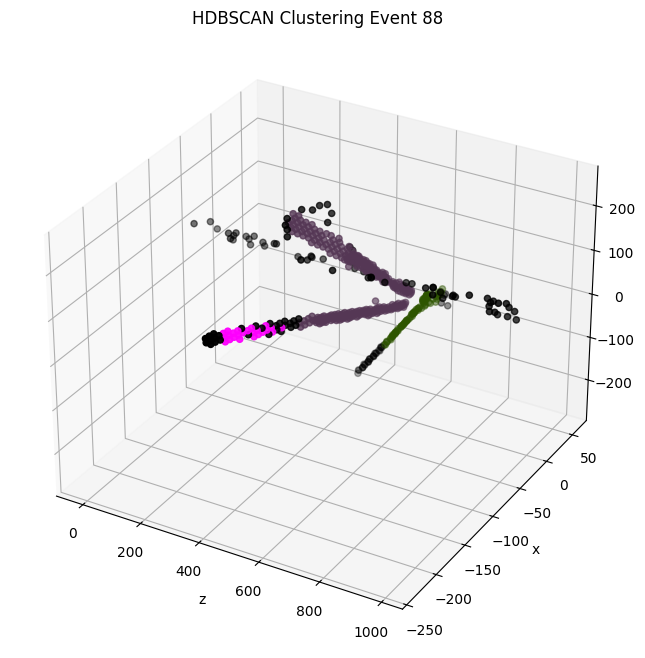

In [20]:
from sklearn.cluster import HDBSCAN
import matplotlib.colors as mcolors

hdbscan_clus = HDBSCAN(min_cluster_size=22, metric='euclidean', algorithm='auto')
# hdbscan_clus = HDBSCAN(min_cluster_size=2,min_samples=1, metric='euclidean', algorithm='auto')
labels_db = hdbscan_clus.fit_predict(X_scaled)
print(np.unique(labels_db))
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ["black", "darkred", "green", "navy", "orange",  "magenta"]

custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_gradient", colors
)
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c=labels_db, cmap=custom_cmap)
plt.title(f"HDBSCAN Clustering Event {event}")
plt.xlabel("z")
plt.ylabel("x")
ax.set_zlabel("y")
plt.show()

# Anomaly and Novelty Detection

## Isolation Forest

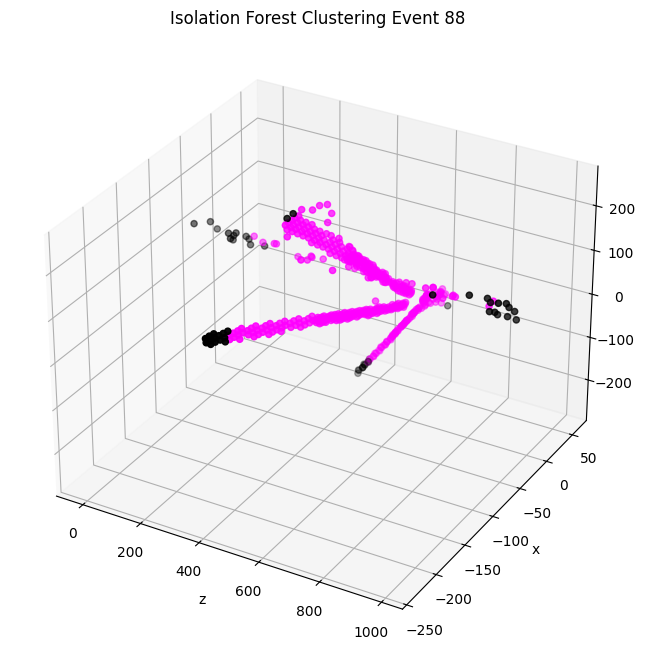

In [21]:
from sklearn.ensemble import IsolationForest
import matplotlib.colors as mcolors

clf = IsolationForest(n_estimators=100, contamination=0.1)
labels_if = clf.fit_predict(X_scaled)

colors = ["black", "darkred", "green", "navy", "orange",  "magenta"]

custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_gradient", colors
)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c=labels_if, cmap=custom_cmap)
plt.title(f"Isolation Forest Clustering Event {event}")
plt.xlabel("z")
plt.ylabel("x")
ax.set_zlabel("y")
plt.show()  

## Local outlier factor

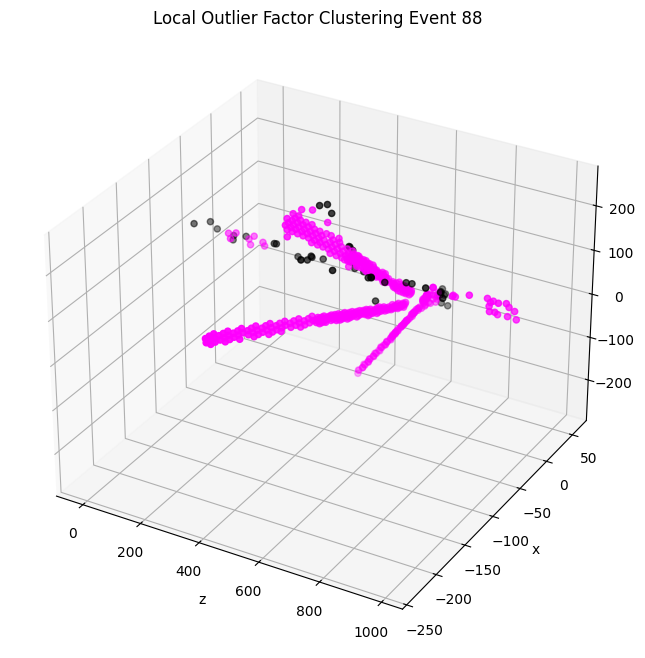

In [22]:
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.colors as mcolors

loal_clf = LocalOutlierFactor(n_neighbors=20, contamination=0.08)
labels_lof = loal_clf.fit_predict(X_scaled) 
colors = ["black", "darkred", "green", "navy", "orange",  "magenta"]    
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_gradient", colors
)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')      
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c=labels_lof, cmap=custom_cmap)
plt.title(f"Local Outlier Factor Clustering Event {event}")
plt.xlabel("z")
plt.ylabel("x")
ax.set_zlabel("y")
plt.show()

## One-class SVM

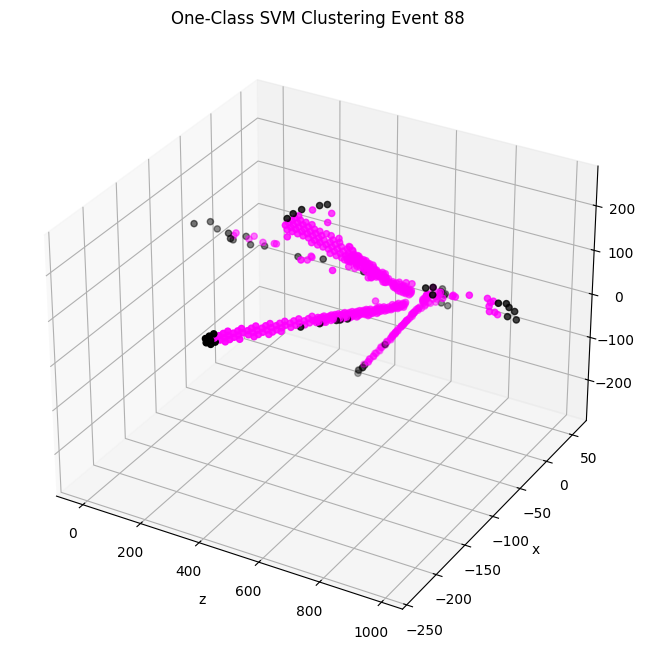

In [23]:
from sklearn.svm import OneClassSVM
import matplotlib.colors as mcolors

colors = ["black", "darkred", "green", "navy", "orange",  "magenta"]    
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    "custom_gradient", colors
)
oc_svm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
labels_ocsvm = oc_svm.fit_predict(X_scaled)         
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 2], X[:, 0], X[:, 1], c=labels_ocsvm, cmap=custom_cmap)
plt.title(f"One-Class SVM Clustering Event {event}")
plt.xlabel("z")
plt.ylabel("x")
ax.set_zlabel("y")
plt.show()